In [1]:
import os
import sys
import cv2
import torch

import numpy as np
import albumentations as album
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

from torchmetrics import JaccardIndex, ConfusionMatrix

sys.path.insert(0, '..')
from loaders.datasets import AmsterdamDataset
from utils.general import visualize
from utils.augmentation import *
from utils.metrics import BlobOverlap

In [2]:
preprocessing_fn = smp.encoders.get_preprocessing_fn('resnet18', 'imagenet')
model = torch.load(os.path.join('..', 'models', 'weights', 'unetpp.pth'))

# images = os.path.join('..', 'data', 'images')
# annotations = os.path.join('..', 'data', 'spectrum-batch-1', 'annotations.json')

images = os.path.join('..', 'data', 'images')
annotations = os.path.join('..', 'data', 'fences-quays', 'annotations', 'test-annotations-6px.json')

data = AmsterdamDataset(images, annotations, preprocessing=get_preprocessing(preprocessing_fn))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [3]:
# print(model)

In [4]:
%matplotlib inline

miou = 0
IoU = JaccardIndex(num_classes=2, reduction='none')
BO = BlobOverlap()


imdir = os.path.join('..', 'data', 'fences-quays', 'images')


preds = []

for i, (image, mask) in enumerate(data):
    print(i)
    img = plt.imread(os.path.join(imdir, data.images[i]['file_name']))
    
    mask = np.squeeze(mask)
    x = torch.as_tensor(image).unsqueeze(0).cuda()
    
    pred = model(x).detach().squeeze().cpu()#.numpy()
    
    BO.update(pred.numpy(), mask.squeeze())
    
#     visualize(image=img,
#               ground_truth=mask,
#               prediction=pred)

#     print(IoU(torch.as_tensor(pred).unsqueeze(0), torch.as_tensor(mask).unsqueeze(0).int()))
    miou += IoU(torch.as_tensor(pred).unsqueeze(0), torch.as_tensor(mask).unsqueeze(0).int())
    
    
    preds.append(pred)
#     if i > 5:
#         break
    
print(miou / (i + 1))
BO.compute()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
tensor([0.9827, 0.6041])


0.8622464576685328

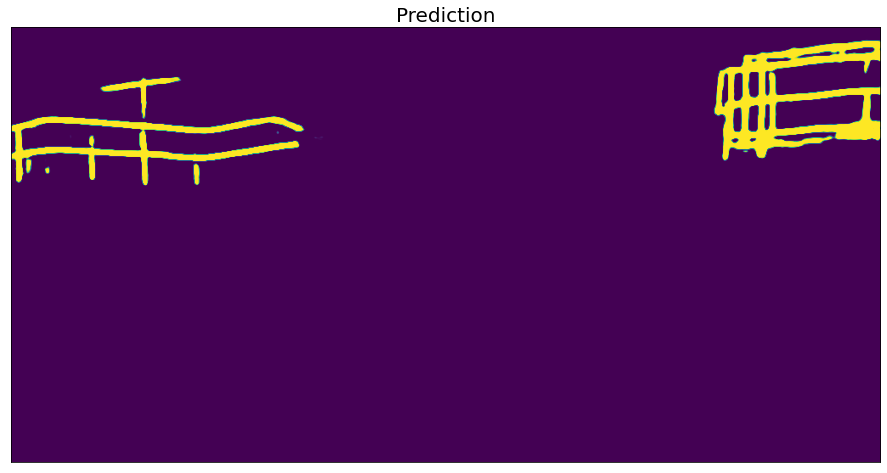

In [5]:
from sklearn.cluster import DBSCAN

idx=68

visualize(prediction=preds[idx])

pred_np = preds[idx].numpy()
ones_xy_mask = np.flip(np.column_stack(np.where(pred_np > 0.5)), axis=1)

labels = DBSCAN(eps=50, min_samples=10).fit(ones_xy_mask)
labels = labels.labels_

#     xmax, ymax = ones_xy_mask.max(axis=0)
#     xmin, ymin = ones_xy_mask.min(axis=0)

#     print(xmax, ymax)
#     print(xmin, ymin)

In [6]:
from scipy.spatial import ConvexHull

first_cluster = ones_xy_mask[np.where(labels == 0)]
ch = ConvexHull(first_cluster)
contour = first_cluster[ch.vertices]

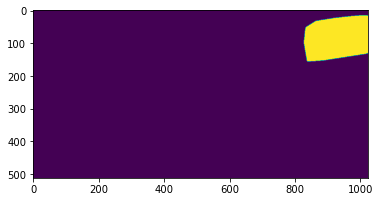

In [7]:
canvas = np.zeros((512, 1024))
cv2.drawContours(canvas, [contour], 0, color=1, thickness=-1)

plt.imshow(canvas)
plt.show()

In [8]:
def to_blobs(mask, threshold=.5, blobber=DBSCAN):
    """
    """
    canvas = np.zeros(mask.shape)
    contours = []
    
    # get all positive prediction coordinates
    coords = np.flip(np.column_stack(np.where(mask > threshold)), axis=1)
    
    # use clustering algorithm to find labels per pixel coordinate
    clustering = blobber(eps=50, min_samples=10).fit(coords)
    coord_labels = clustering.labels_
    
    # get non noisy cluster labels
    labels = np.unique(coord_labels)
    labels = labels[labels >= 0]
    
    for label in labels:
        cluster = coords[coord_labels == label]
        contour = cluster[ConvexHull(cluster).vertices]
        
        contours.append(contour)
    
    return cv2.drawContours(canvas, contours, -1, 1, -1)
    

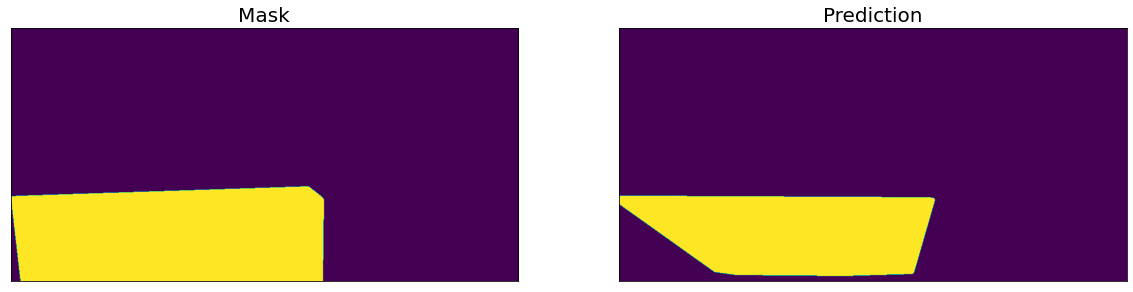

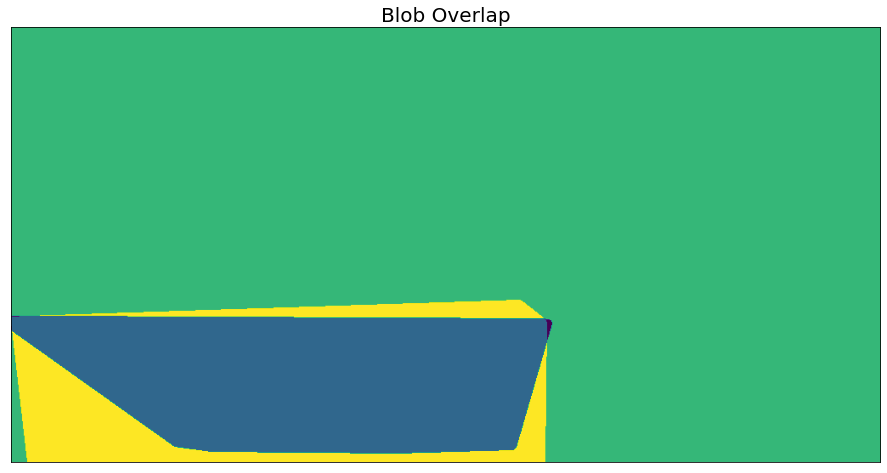

0.7405475532491537

In [9]:
idx = 84

mask_blobs = to_blobs(data[idx][1].squeeze())
pred_blobs = to_blobs(preds[idx].numpy())

pred_blobs[pred_blobs == 0] = -1

blob_overlap = (mask_blobs - pred_blobs)

visualize(mask=mask_blobs, prediction=pred_blobs)
visualize(blob_overlap=blob_overlap)

np.count_nonzero(blob_overlap == 0) / np.count_nonzero(mask_blobs == 1)